In [11]:
from collections import namedtuple
import hashlib
import os
from os.path import join as joinpath, exists as pathexists
import pickle
import sys
import warnings


from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import glob
import os

%matplotlib inline

In [12]:
results_dir='/home/samuel/data/drift_tool_test/salish_test_20170416/output/'
# Use glob to find all netcdf files in results_dir
files = glob.glob(os.path.join(results_dir, '*.nc'))

In [13]:
files

['/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017042000_P1D-604_1491894016.nc',
 '/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017041900_P1D-602_1491901137.nc',
 '/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017041900_P1D-626_1491932630.nc',
 '/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017042000_P1D-125_1491883655.nc',
 '/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017042000_P1D-133_1491850385.nc',
 '/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017041900_P1D-615_1491972004.nc',
 '/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017041900_P1D-612_1492006399.nc',
 '/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017042000_P1D-593_1492105641.nc',
 '/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishse

In [5]:
unique_list =[]
for file in files:
    # Open dataset
    ds = xr.open_dataset(file)
    drift_id = ds.obs_unique_id
    if drift_id not in unique_list:
        unique_list.append(drift_id)
    ds.close()
print(unique_list)

['604_1491894016', '602_1491901137', '626_1491932630', '125_1491883655', '133_1491850385', '615_1491972004', '612_1492006399', '593_1492105641', '606_1491906609', '132_1491850313']


In [6]:
 def plot_file(fname,m,bbox):
    """Plot the modelled and observed trajector in a file fname"""
    ds = xr.open_dataset(fname)
    m.drawcoastlines()
    x, y = m(ds.obs_lon.values, ds.obs_lat.values)
    j,k = m(ds.mod_lon.values, ds.mod_lat.values)
    m.plot(x, y, c='y', label='observations')
    m.plot(x[0], y[0], 'go')
    m.plot(x[-1], y[-1], 'ro')
    cm = plt.cm.get_cmap('viridis')
    mesh =m.scatter(j, k,c=ds.sep.values,marker='o', s=15,vmin=0, vmax=10000,label='model',cmap=cm)
    m.colorbar(mesh)
    m.plot(j[0], k[0], 'go')
    m.plot(j[-1], k[-1], 'ro')
        # fill continents, set lake color same as ocean color. 
    m.fillcontinents(color='white',lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')
    plt.title('Drifter {}'.format(ds.obs_buoyid), fontsize = 15)
    dlat = (bbox.lat_max - bbox.lat_min)/3
    dlon = (bbox.lon_max - bbox.lon_min)/3
    parallels = np.arange(np.floor(bbox.lat_min), np.ceil(bbox.lat_max), dlat)
    m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=9,
                             linewidth=0.5, color='0.5')
    meridians = np.arange(np.floor(bbox.lon_min), np.ceil(bbox.lon_max), dlon)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=9,
                             linewidth=0.5, color='0.5')
    # handle duplicated legends 
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    plt.legend(handle_list, label_list, fontsize=15)

    ds.close()

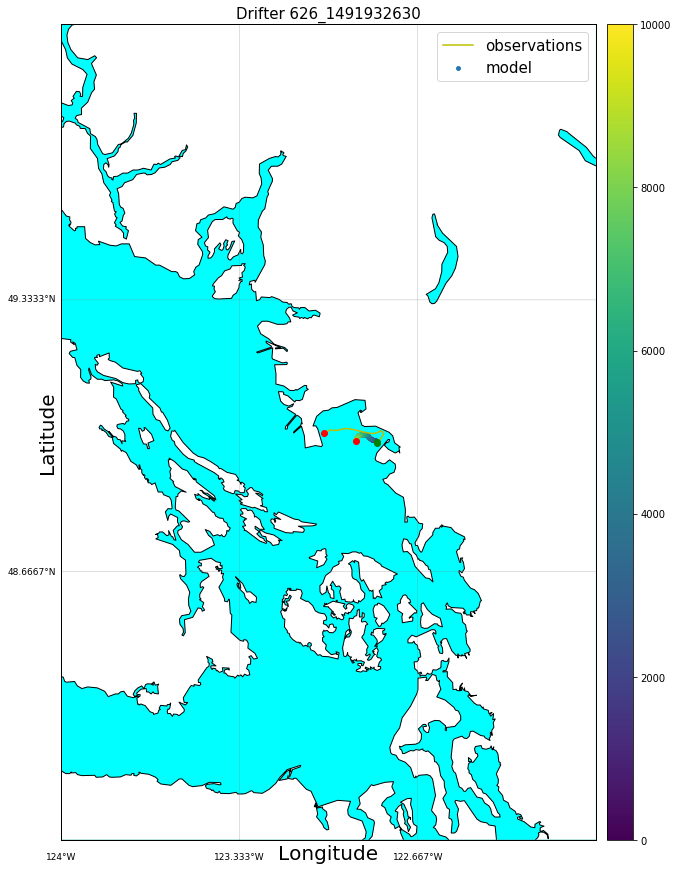

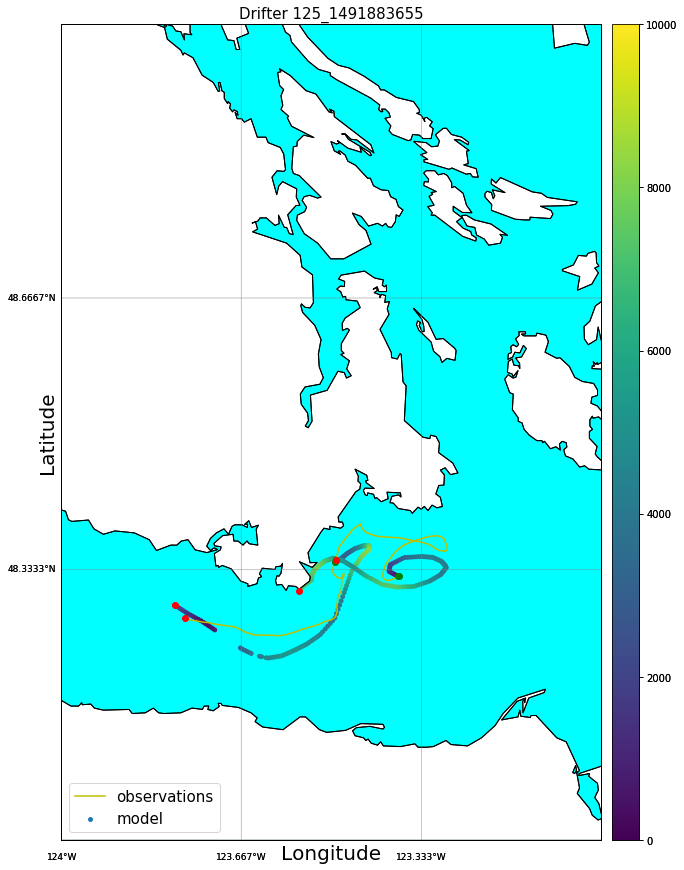

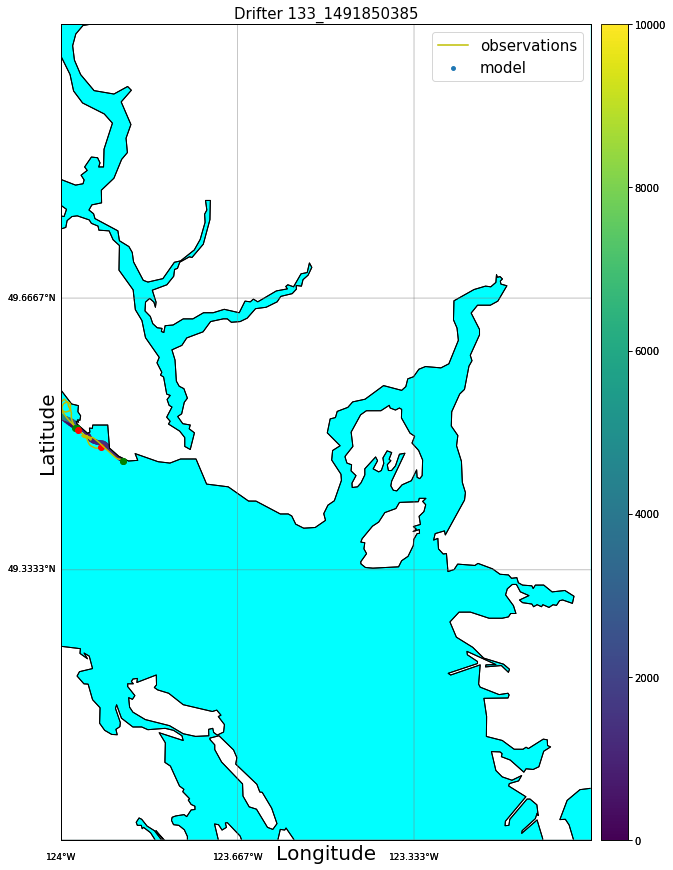

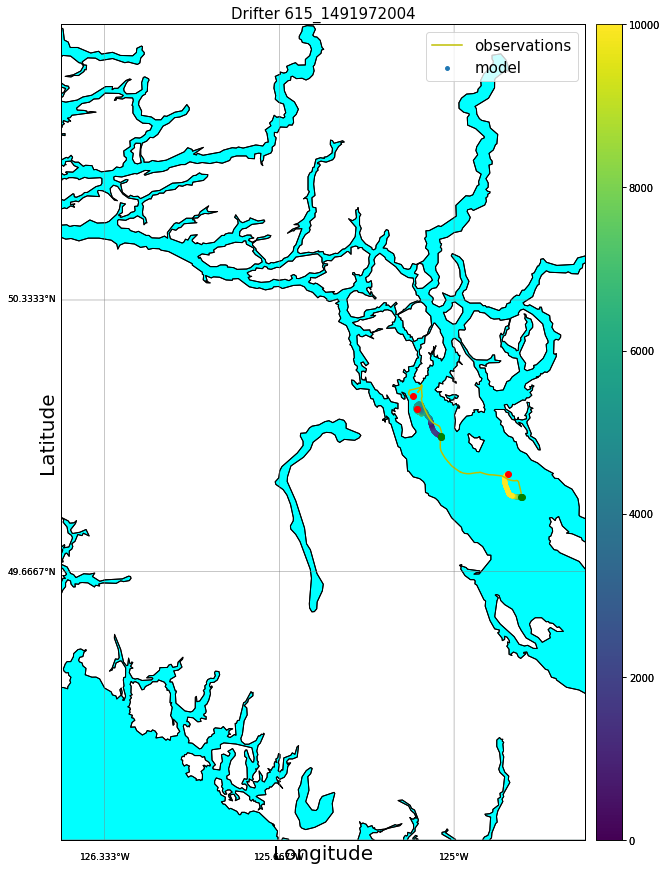

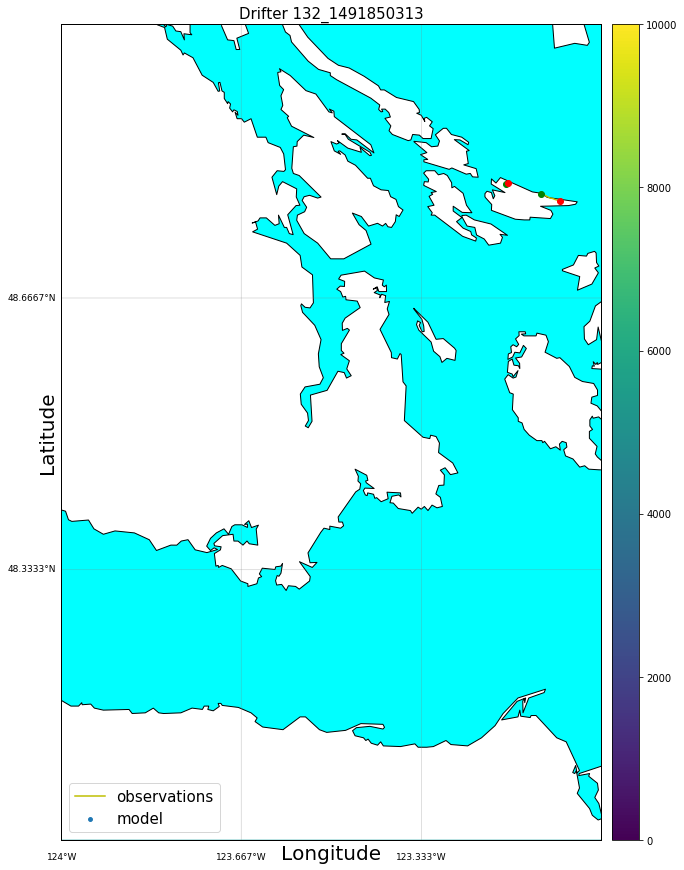

In [32]:
results_dir='/home/samuel/data/drift_tool_test/salish_test_20170416/output/'
filelist = []

for num in unique_list:
    filename = '*{}.nc'.format(num)
    files = glob.glob(os.path.join(results_dir, filename))
    filelist.append(files)
    fig, ax = plt.subplots(1,1)
    ax.set_xlabel('Longitude', fontsize=20)
    ax.set_ylabel('Latitude', fontsize=20)
    for file in files:
        ds = xr.open_dataset(file)
        bbox = determine_latlon_bbox_for_drifters(ds)
    maplot = Basemap(projection='merc',resolution='h',llcrnrlon=bbox.lon_min,llcrnrlat=bbox.lat_min,urcrnrlon=bbox.lon_max,urcrnrlat=bbox.lat_max)    
    for file in files:
        plot_file(file,maplot,bbox)

In [8]:
LatLonBoundingBox = namedtuple('LatLonBoundingBox',
                               ('lat_min', 'lat_max', 'lon_min', 'lon_max'))
def determine_latlon_bbox_for_drifters(ds):
    """Determine the latitude and longitude bounding box for drifter tracks.

    Parameters
    ----------
    drifters : list of xarray.Dataset
        List of drifter tracks. Each drifter must be ``an xarray.Dataset`` with
        variables ``lat`` and ``lon``.

    Returns
    -------
    bbox : LatLonBoundingBox
    """
    # These initial values are outside the valid ranges for latitudes and
    # longitudes, and are guaranteed to change on the first loop below.
    lat_min = 1000.
    lon_min = 1000.
    lat_max = -1000.
    lon_max = -1000.
    for drifter in ds:
        drifter_lat_min = ds.obs_lat.values.min()
        drifter_lat_max = ds.obs_lat.values.max()
        drifter_lon_min = ds.obs_lon.values.min()
        drifter_lon_max = ds.obs_lon.values.max()
        lat_min = min(drifter_lat_min, lat_min)
        lat_max = max(drifter_lat_max, lat_max)
        lon_min = min(drifter_lon_min, lon_min)
        lon_max = max(drifter_lon_max, lon_max)

    lat_min = np.floor(lat_min)
    lat_max = np.ceil(lat_max)
    lon_min = np.floor(lon_min)
    lon_max = np.ceil(lon_max)
    lat_diff = lat_max - lat_min
    lon_diff = lon_max - lon_min
    if lat_diff > lon_diff:
        cen = lon_min + 0.5 * lon_diff
        lon_min = cen - 0.5 * lat_diff
        lon_max = cen + 0.5 * lat_diff
    else:
        cen = lat_min + 0.5 * lat_diff
        lat_min = cen - 0.5 * lon_diff
        lat_max = cen + 0.5 * lon_diff

    return LatLonBoundingBox(lon_min=lon_min, lat_min=lat_min,
                             lon_max=lon_max, lat_max=lat_max)

llon -124.0 llat 49.0 ulo -123.0 ulat 50.0


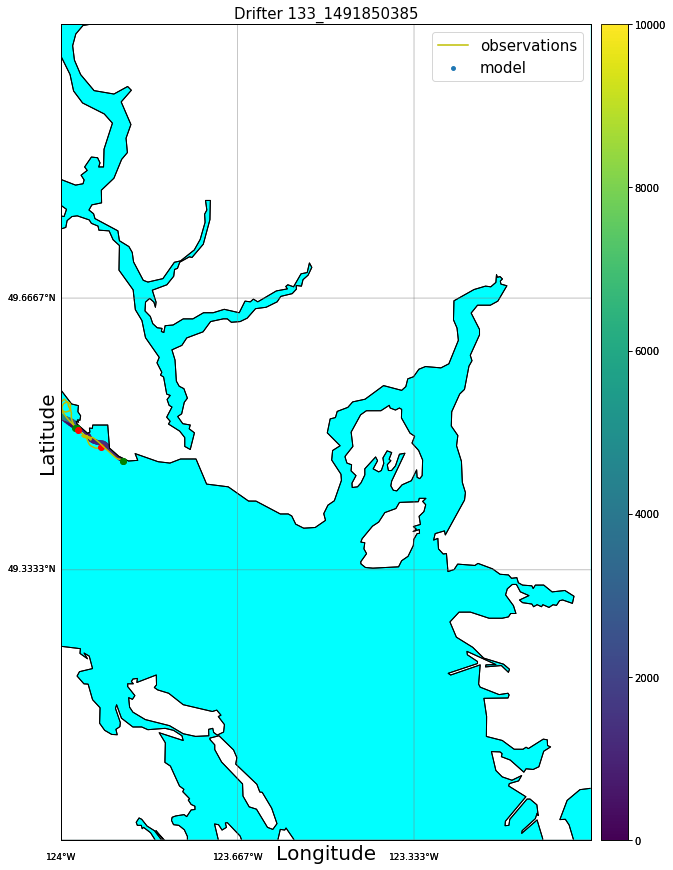

In [37]:
fig, ax = plt.subplots(1,1)
n = 4
for file in filelist[n]:
    ax.set_xlabel('Longitude', fontsize=20)
    ax.set_ylabel('Latitude', fontsize=20)
    ds = xr.open_dataset(file)
    bbox = determine_latlon_bbox_for_drifters(ds)
maplot = Basemap(projection='merc',resolution='h',llcrnrlon=bbox.lon_min,llcrnrlat=bbox.lat_min,urcrnrlon=bbox.lon_max,urcrnrlat=bbox.lat_max)    
for file in filelist[n]:
    plt.rcParams['figure.figsize'] = [12, 15]
    plot_file(file,maplot,bbox)
print('llon {} llat {} ulo {} ulat {}'.format(bbox.lon_min,bbox.lat_min,bbox.lon_max,bbox.lat_max))

In [162]:
cm = plt.cm.get_cmap('RdYlBu')
xy = ds.sep
z = xy
mesh=plt.scatter(ds.mod_lon.values, ds.mod_lat.values, c=z, s=35, cmap=cm)
plt.colorbar(mesh)
plt.show()

In [156]:
print (ds.sep.values.min())

173.10307247


In [27]:
filelist[3]

['/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017042000_P1D-125_1491883655.nc',
 '/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017041900_P1D-125_1491883655.nc']